Integration successful.


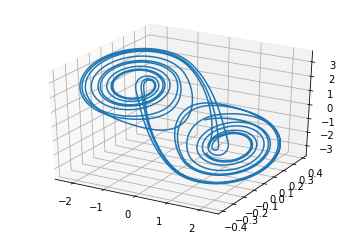

In [79]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
import importlib
from numpy import random
importlib.import_module('mpl_toolkits.mplot3d').__path__
%matplotlib inline
np.random.seed(0)

#define universal variables
c0 = 15.6
c1 = 1.0
c2 = 28.0
m0 = -1.143
m1 = -0.714

#just a little extra, quite unimportant
def f(x):
    f = m1*x+(m0-m1)/2.0*(abs(x+1.0)-abs(x-1.0))
    return f

#the actual function calculating
def dH_dt(H, t=0):
    return np.array([c0*(H[1]-H[0]-f(H[0])),
                  c1*(H[0]-H[1]+H[2]),
                  -c2*H[1]])


#computational time steps
t = np.linspace(0, 30, 10000)
#x, y, and z initial conditions
H0 = [0.7, 0.0, 0.0]

H, infodict = integrate.odeint(dH_dt, H0, t, full_output=True)

print (infodict['message'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(H[:,0], H[:,1], H[:,2])
plt.show()



x = H[:,0]
y = H[:,1]
z = H[:,2]

In [143]:
def FFT_surrogates(ts):
    """
    Return Fourier surrogates.
    
    Generate surrogates by Fourier transforming the time series, randomizing the phases and
    then applying an inverse Fourier transform. Correlated noise surrogates
    share their power spectrum and autocorrelation function with the
    original_data time series.

    Input type: timeseries array 
    Return: The surrogate time series.
    """
    #  Calculate FFT of original_data time series
    ts_fourier  = np.fft.rfft(ts)
    random_phases = np.exp(np.random.uniform(0,np.pi,len(ts)//2+1)*1.0j)
    ts_fourier_new = ts_fourier*random_phases
    new_ts = np.fft.irfft(ts_fourier_new)
    
    return new_ts

In [111]:
def AAFT_surrogates(ts):
    """
    Return surrogates using the amplitude adjusted Fourier transform
    method.

    Input: Orinal time series
    Return: The surrogate time series.
    """
    index = [i for i in range(len(ts))]
    con_ts = np.array([index,ts])
    
    #  Create sorted Gaussian reference series
    gaussian = random.randn(con_ts.shape[0], con_ts.shape[1])
    gaussian.sort(axis=1)

    #  Rescale data to Gaussian distribution
    ranks = con_ts.argsort(axis=1).argsort(axis=1)
    rescaled_data = np.zeros(con_ts.shape)

    for i in range(con_ts.shape[0]):
        rescaled_data[i, :] = gaussian[i, ranks[i, :]]

    #  Phase randomize rescaled data
    phase_randomized_data = Fourier_surrogates(ts)
    phase_randomized_data = np.array([index,phase_randomized_data])

    #  Rescale back to amplitude distribution of original data
    sorted_original = con_ts.copy()
    sorted_original.sort(axis=1)

    ranks = phase_randomized_data.argsort().argsort()

    for i in range(con_ts.shape[0]):
        rescaled_data[i, :] = sorted_original[i, ranks[i,:]]

    return rescaled_data[1]


In [129]:
def refined_AAFT_surrogates(ts,n_iterations,output="true_amplitudes"):
    """
    Return surrogates using the iteratively refined amplitude adjusted
    Fourier transform method.

    A set of AAFT surrogates (:meth:`AAFT_surrogates`) is iteratively
    refined to produce a closer match of both amplitude distribution and
    power spectrum of surrogate and original data.

    :arg int n_iterations: Number of iterations / refinement steps
    :arg str output: Type of surrogate to return. "true_amplitudes":
        surrogates with correct amplitude distribution, "true_spectrum":
        surrogates with correct power spectrum, "both": return both outputs
        of the algorithm.
    Input: Orinal time series
    Return: The surrogate time series.
    """
    #  Get size of dimensions
    index = [i for i in range(len(ts))]
    original_data = np.array([index,ts])
    n_time = original_data.shape[1]

    #  Get Fourier transform of original data with caching
    fourier_transform = np.fft.rfft(original_data, axis=1)
    original_data_fft = fourier_transform


    #  Get Fourier amplitudes
    original_fourier_amps = np.abs(fourier_transform)

    #  Get sorted copy of original data
    sorted_original = original_data.copy()
    sorted_original.sort(axis=1)

    #  Get starting point / initial conditions for R surrogates
    # (see [Schreiber2000]_)
    R = AAFT_surrogates(original_data[1])
    index = [i for i in range(len(R))]
    R = np.array([index,R])

    #  Start iteration
    for i in range(n_iterations):
        #  Get Fourier phases of R surrogate
        r_fft = np.fft.rfft(R, axis=1)
        r_phases = r_fft / np.abs(r_fft)

        #  Transform back, replacing the actual amplitudes by the desired
        #  ones, but keeping the phases exp(iψ(i)
        s = np.fft.irfft(original_fourier_amps * r_phases, n=n_time,
                         axis=1)

        #  Rescale to desired amplitude distribution
        ranks = s.argsort(axis=1).argsort(axis=1)

        for j in range(original_data.shape[0]):
            R[j, :] = sorted_original[j, ranks[j, :]]

    if output == "true_amplitudes":
        return R[1]
    elif output == "true_spectrum":
        return s[1]


In [154]:
def plot_autocorrelation(new_ts,sur = False):
    pd.tools.plotting.autocorrelation_plot(new_ts)
    plt.ylim([-1,1])
    if sur:
        plt.title('Autocorrelation function of surrogate time series')
    else:
        plt.title('Autocorrelation function of original time series')
    plt.show()
    
    
def plot_ts_comparision(ts,new_ts,ran = 1000):
    plt.plot(ts[0:ran],label='original time series')
    plt.plot(new_ts[0:ran],label='surrogate time series')
    plt.legend()
    plt.title('Comparison between original time series and surrogate time series')
    plt.show()

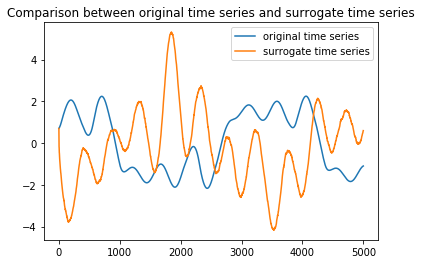

/Users/songzeli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


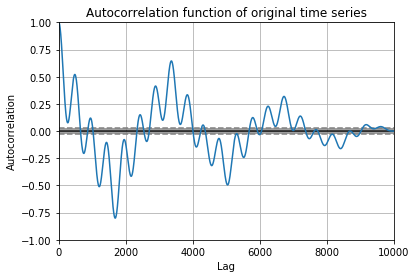

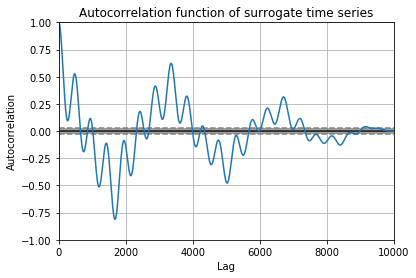

In [157]:
new_ts = FFT_surrogates(z)
plot_ts_comparision(x,new_ts,5000)
plot_autocorrelation(z)
plot_autocorrelation(new_ts,sur=True)

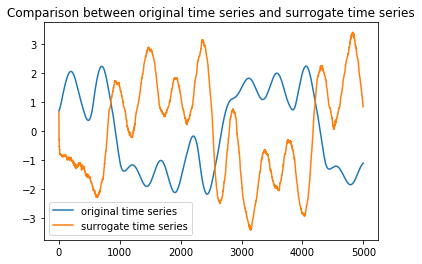

/Users/songzeli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


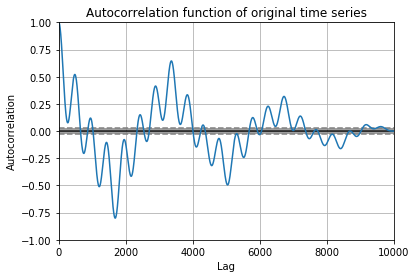

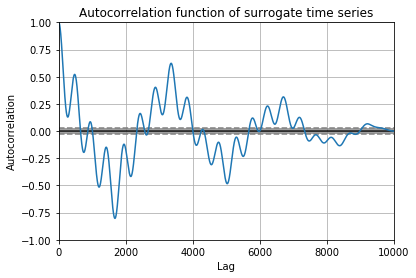

In [158]:
new_ts = AAFT_surrogates(z)
plot_ts_comparision(x,new_ts,5000)
plot_autocorrelation(z)
plot_autocorrelation(new_ts,sur=True)

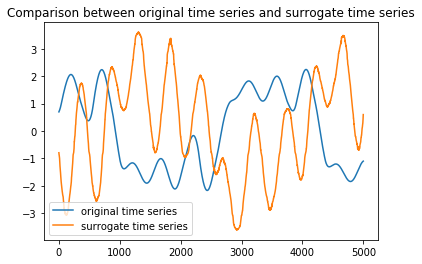

/Users/songzeli/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


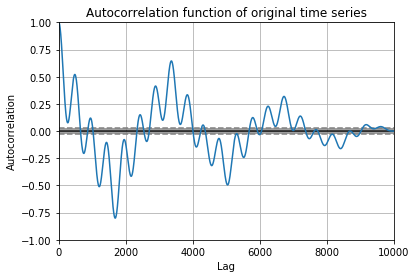

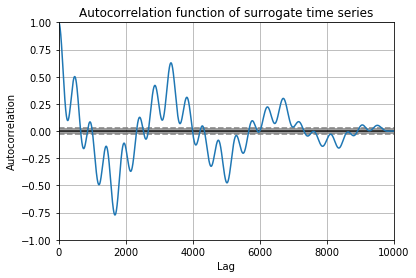

In [159]:
new_ts = refined_AAFT_surrogates(z,5000)
plot_ts_comparision(x,new_ts,5000)
plot_autocorrelation(z)
plot_autocorrelation(new_ts,sur=True)